In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_14563/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


输入数据为$(x_1, x_2, t)$

输出数据为$(u_{x_1}, u_{x_2}, v, p)$

In [2]:
import os
import shutil

import numpy as np
import time
from pyDOE import lhs
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

In [3]:
import argparse
class Options_NS:
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--cuda', default=True, help='if you use cuda')
        
        parser.add_argument('--T', type=float, default=1., help='a float T of time domain [0, T]')
        parser.add_argument('--N_r', default=20000, help='num of interior points')
        parser.add_argument('--N_b', default=6000, help='num of boundary points')
        
        parser.add_argument('--backbone_layers', type=list, default=([3] + [60]*5 + [4]), help='list of nn layers of backbone')
        
        parser.add_argument('--backbone_lr', type=float, default=1e-3, help='initial learning rate of backbone')
        
        parser.add_argument('--gamma', type=float, default=0.95, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--iters', type=int, default=20000, help='iters or epochs for Adam optimizer')
        parser.add_argument('--lam_res', type=float, default=1, help='weight of loss_res')
        parser.add_argument('--lam_bcs', type=float, default=1, help='weight of loss_bcs')
        
        self.parser = parser

    def parse_default(self):
        args = self.parser.parse_args(args=[])
        args.device = torch.device('cuda' if args.cuda else 'cpu')
        return args
    

args = Options_NS().parse_default()
print(args.cuda)

True


In [4]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth')
        shutil.copyfile(last_model, best_model)

def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [5]:
seed_torch(42)

## 网络模型 (Modified ResNet / ResNet / Modified MLP / MLP)

In [6]:
class ModifiedResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedResNet, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X_ = X_ / 2.
            X_ = (1 - X_) * u + X_ * v
            X = X_ + X
        return self.model[-1](X)

In [7]:
class ResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ResNet, self).__init__()
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X = X_ + X
        return self.model[-1](X)

In [8]:
class ModifiedMLP(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedMLP, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        for i in range(len(self.model) - 1):
            X = self.model[i](X)
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)

In [9]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)

In [10]:
backbone = ResNet(args.backbone_layers)
backbone = backbone.to(args.device)
args.backbone = backbone
print(args.backbone)

ResNet(
  (model): Sequential(
    (first): Sequential(
      (fc0): Linear(in_features=3, out_features=60, bias=True)
      (act0): Tanh()
    )
    (block1): Sequential(
      (fc1_0): Linear(in_features=60, out_features=60, bias=True)
      (act1_0): Tanh()
      (fc1_1): Linear(in_features=60, out_features=60, bias=True)
      (act1_1): Tanh()
    )
    (block2): Sequential(
      (fc2_0): Linear(in_features=60, out_features=60, bias=True)
      (act2_0): Tanh()
      (fc2_1): Linear(in_features=60, out_features=60, bias=True)
      (act2_1): Tanh()
    )
    (block3): Sequential(
      (fc3_0): Linear(in_features=60, out_features=60, bias=True)
      (act3_0): Tanh()
      (fc3_1): Linear(in_features=60, out_features=60, bias=True)
      (act3_1): Tanh()
    )
    (block4): Sequential(
      (fc4_0): Linear(in_features=60, out_features=60, bias=True)
      (act4_0): Tanh()
      (fc4_1): Linear(in_features=60, out_features=60, bias=True)
      (act4_1): Tanh()
    )
    (last): Se

## 数据集生成

In [11]:
class Dataset_NS:
    def __init__(self, T, device, N_max=100000):
        self.T = T
        self.device = device
        self.N_max = N_max
        self.x1_range = (0, 1)
        self.x2_range = (-1, 1)
    
    def train_data(self, N_r, N_b):
        # 采样
        X_res, f_x1, f_x2 = self.interior(N_r)
        X_bcs, u_bcs = self.boundary(N_b)
        # 转移到device
        X_res = X_res.to(self.device)
        X_bcs = X_bcs.to(self.device)
        f_x1 = f_x1.to(self.device)
        f_x2 = f_x2.to(self.device)
        u_bcs = u_bcs.to(self.device)
        
        return X_res, X_bcs, f_x1, f_x2, u_bcs
    
    def interior(self, N_r):
        """内部点采样"""
        X1 = torch.Tensor(self.N_max, 1).uniform_(*self.x1_range)
        X2 = torch.Tensor(self.N_max, 1).uniform_(*self.x2_range)
        T = torch.Tensor(self.N_max, 1).uniform_(0, self.T)
        
        idx = torch.randperm(self.N_max)
        idx = idx[:N_r]
        X_res = torch.cat([X1[idx], X2[idx], T[idx]], dim=1)
        
        g = 9.8
        s = 0.001
        f_x1 = torch.Tensor(N_r, 1).fill_(g*s)
        f_x2 = torch.Tensor(N_r, 1).fill_(0.)
        return X_res, f_x1, f_x2
    
    def boundary(self, N_b):
        """边界点采样"""
        N_b = N_b // 3
        
        # (x1, -1, t)
        X1 = torch.Tensor(self.N_max, 1).uniform_(*self.x1_range)
        X2 = torch.Tensor(self.N_max, 1).fill_(-1.)
        T = torch.Tensor(self.N_max, 1).uniform_(0, self.T)
        idx = torch.randperm(self.N_max)
        idx = idx[:N_b]
        X_bcs1 = torch.cat([X1[idx], X2[idx], T[idx]], dim=1)
        
        u_bcs1 = torch.Tensor(N_b, 1).fill_(0.2)
        
        # (x1, 1, t)
        X1 = torch.Tensor(self.N_max, 1).uniform_(*self.x1_range)
        X2 = torch.Tensor(self.N_max, 1).fill_(1.)
        T = torch.Tensor(self.N_max, 1).uniform_(0, self.T)
        idx = torch.randperm(self.N_max)
        idx = idx[:N_b]
        X_bcs2 = torch.cat([X1[idx], X2[idx], T[idx]], dim=1)
        
        u_bcs2 = torch.Tensor(N_b, 1).fill_(0.2)
        
        # (0, x2, t)
        X1 = torch.Tensor(self.N_max, 1).fill_(0.)
        X2 = torch.Tensor(self.N_max, 1).uniform_(*self.x2_range)
        T = torch.Tensor(self.N_max, 1).uniform_(0, self.T)
        idx = torch.randperm(self.N_max)
        idx = idx[:N_b]
        X_bcs3 = torch.cat([X1[idx], X2[idx], T[idx]], dim=1)
        
        u_bcs3 = torch.Tensor(N_b, 1).fill_(0.)
        
        X_bcs = torch.cat([X_bcs1, X_bcs2, X_bcs3], dim=0)
        u_bcs = torch.cat([u_bcs1, u_bcs2, u_bcs3], dim=0)
        return X_bcs, u_bcs


dataset = Dataset_NS(args.T, args.device)
args.dataset = dataset
X_res, X_bcs, f_x1, f_x2, u_bcs = dataset.train_data(args.N_r, args.N_b)
print(X_res.shape, X_bcs.shape, f_x1.shape, f_x2.shape, u_bcs.shape)

torch.Size([20000, 3]) torch.Size([6000, 3]) torch.Size([20000, 1]) torch.Size([20000, 1]) torch.Size([6000, 1])


## 训练

In [12]:
class Trainer_PoissonHD:
    def __init__(self, args):
        self.args = args
        self.device = args.device
        
        self.N_r = args.N_r
        self.N_b = args.N_b
        self.dataset = args.dataset
        
        self.lam_res = args.lam_res
        self.lam_bcs = args.lam_bcs
        self.gamma = args.gamma
        self.backbone = args.backbone
        
        self.model_name = self.backbone.__class__.__name__
        self.model_path = self.get_model_path()
        
        self.iters = args.iters

        # eps = np.finfo(np.float32).eps
        self.optimizer_Adam = optim.Adam(self.backbone.parameters(), lr=args.backbone_lr, betas=(0.9, 0.999))
        
        self.step_size = 1000#int( self.iters_stage4 / (np.log(1e-3) / np.log(self.gamma)) )
        self.scheduler = ExponentialLR(self.optimizer_Adam, gamma=self.gamma, verbose=True)
        
        # data
        self.X_res, self.X_bcs, self.f_x1, self.f_x2, self.u_bcs = self.dataset.train_data(self.N_r, self.N_b)
        self.rho = 1.
        
        # Logger
        self.logger = {
            "loss": [],
            "loss_res": [],
            "loss_bcs": [],
            "iter": [],
        }
        self.logger_valid = {
            "loss": [],
            "loss_res": [],
            "loss_bcs": [],
            "iter": [],
            "error": [],  # relative l2 error
        }
        
    def get_model_path(self):
        # 保存模型的路径
        if not os.path.exists('models'):
            os.mkdir('models')
        
        path = os.path.join('models', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        
        return path
        
    def update_train_data(self):
        # 更新采样点
        self.X_res, self.X_bcs, self.f_x1, self.f_x2, self.u_bcs = self.dataset.train_data(self.N_r, self.N_b)

    def net_u(self, X):
        return self.backbone(X)

    def net_r(self, x1x2t):
        x1x2t.requires_grad_(True)
        
        u1u2vp = self.net_u(x1x2t)
        
        u1 = u1u2vp[:, [0]]
        u2 = u1u2vp[:, [1]]
        v = u1u2vp[:, [2]]
        p = u1u2vp[:, [3]]
        
        # u对时间求导
        grad_u1 = grad(u1, x1x2t)[0]
        grad_u2 = grad(u2, x1x2t)[0]
        u1_t = grad_u1[:, [2]]
        u2_t = grad_u2[:, [2]]
        
        # u对空间求导
        u1_x1 = grad_u1[:, [0]]
        u1_x2 = grad_u1[:, [1]]
        u2_x1 = grad_u2[:, [0]]
        u2_x2 = grad_u2[:, [1]]
        
        # u对空间求二阶导
        u1_x1x1 = grad(u1_x1, x1x2t)[0][:, [0]]
        u1_x2x2 = grad(u1_x2, x1x2t)[0][:, [1]]
        u2_x1x1 = grad(u2_x1, x1x2t)[0][:, [0]]
        u2_x2x2 = grad(u2_x2, x1x2t)[0][:, [1]]
        
        # p对空间求导
        grad_p = grad(p, x1x2t)[0]
        p_x1 = grad_p[:, [0]]
        p_x2 = grad_p[:, [1]]
        
        # 控制方程
        f_x1_pred = u1_t + u1*u1_x1 + u2*u1_x2 + p_x1/self.rho - v*(u1_x1x1 + u1_x2x2)
        
        f_x2_pred = u2_t + u1*u2_x1 + u2*u2_x2 + p_x2/self.rho - v*(u2_x1x1 + u2_x2x2)
        
        h_pred = u1_x1 + u2_x2

        return f_x1_pred, f_x2_pred, h_pred
    
    def compute_loss(self):
        # 计算loss
        f_x1_pred, f_x2_pred, h_pred = self.net_r(self.X_res)
        self.loss_res = (
            torch.mean((f_x1_pred - self.f_x1) ** 2) + \
            torch.mean((f_x2_pred - self.f_x2) ** 2) + \
            torch.mean(h_pred ** 2)
        )
        
        u_bcs_pred = self.net_u(self.X_bcs)
        self.loss_bcs = torch.mean((u_bcs_pred - self.u_bcs) ** 2)

        self.loss = self.lam_res * self.loss_res + self.lam_bcs * self.loss_bcs


    def log_loss(self):
        # 记录当前loss至logger字典
        self.logger["loss"].append(self.loss.item())
        self.logger["loss_res"].append(self.loss_res.item())
        self.logger["loss_bcs"].append(self.loss_bcs.item())
        self.logger["iter"].append(self.iter + 1)

    def log_info(self):
        """保存并打印训练信息"""
        # 从logger中读取的为训练信息
        loss = self.logger["loss"][-1]
        loss_r = self.logger["loss_res"][-1]
        loss_b = self.logger["loss_bcs"][-1]
        
        info = f'Iter {self.iter+1:5d} Time:{time.time()-self.start_time:.1e} # ' + \
               f'Loss:{loss:.2e}, Loss_r:{loss_r:.2e}, Loss_b:{loss_b:.2e} # ' + \
               f'Valid:{self.valid_loss_value:.2e}'
        with open("train_info.txt", 'a') as f:
            f.write(info + '\n')
        print(info)

    def valid(self):
        """验证并保存最优模型"""
        # 计算loss
        X_res, X_bcs, f_x1, f_x2, u_bcs = self.dataset.train_data(1000, 1000)
        self.backbone.eval()
        
        f_x1_pred, f_x2_pred, h_pred = self.net_r(X_res)
        loss_res = (
            torch.mean((f_x1_pred - f_x1) ** 2) + \
            torch.mean((f_x2_pred - f_x2) ** 2) + \
            torch.mean(h_pred ** 2)
        )
        
        u_bcs_pred = self.net_u(X_bcs)
        loss_bcs = torch.mean((u_bcs_pred - u_bcs) ** 2)
        
        loss = self.lam_res * loss_res + self.lam_bcs * loss_bcs
        
        # 记录valid的loss和rl2 error信息
        self.logger_valid["loss"].append(loss.item())
        self.logger_valid["loss_res"].append(loss_res.item())
        self.logger_valid["loss_bcs"].append(loss_bcs.item())
        self.logger_valid["iter"].append(self.iter + 1)
        
        # 验证模型loss是否最优并选择保存
        self.valid_loss_value = loss.item()
        is_best = self.valid_loss_value < self.best_loss
        if is_best:
            self.best_loss = self.valid_loss_value
        state = {
            'iter': self.iter+1,
            'state_dict': self.backbone.state_dict(),
            'best_loss': self.best_loss
        }
        save_model(state, is_best, save_dir=self.model_path)
    
    def train(self):
        self.start_time = time.time()
        self.best_loss = 1.e10
        
        self.iter = 0
        for _ in range(self.iters):
            self.optimizer_Adam.zero_grad()
            self.compute_loss()
            self.loss.backward()
            self.optimizer_Adam.step()
            self.log_loss()

            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data()

            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
            self.iter += 1
            
            
trainer = Trainer_PoissonHD(args)

Adjusting learning rate of group 0 to 1.0000e-03.


In [13]:
trainer.train()

Iter   100 Time:4.5e+00 # Loss:5.41e-03, Loss_r:2.16e-04, Loss_b:5.20e-03 # Valid:5.44e-03
Iter   200 Time:8.8e+00 # Loss:4.23e-03, Loss_r:2.17e-04, Loss_b:4.01e-03 # Valid:4.19e-03
Iter   300 Time:1.3e+01 # Loss:3.32e-03, Loss_r:2.60e-04, Loss_b:3.06e-03 # Valid:3.35e-03
Iter   400 Time:1.8e+01 # Loss:3.14e-03, Loss_r:1.85e-04, Loss_b:2.96e-03 # Valid:3.37e-03
Iter   500 Time:2.2e+01 # Loss:3.02e-03, Loss_r:1.57e-04, Loss_b:2.87e-03 # Valid:2.80e-03
Iter   600 Time:2.6e+01 # Loss:2.85e-03, Loss_r:1.31e-04, Loss_b:2.72e-03 # Valid:2.99e-03
Iter   700 Time:3.1e+01 # Loss:2.69e-03, Loss_r:1.21e-04, Loss_b:2.57e-03 # Valid:2.71e-03
Iter   800 Time:3.5e+01 # Loss:2.78e-03, Loss_r:1.50e-04, Loss_b:2.64e-03 # Valid:2.72e-03
Iter   900 Time:3.9e+01 # Loss:2.62e-03, Loss_r:1.05e-04, Loss_b:2.51e-03 # Valid:2.65e-03
Iter  1000 Time:4.4e+01 # Loss:2.47e-03, Loss_r:1.04e-04, Loss_b:2.36e-03 # Valid:2.53e-03
Adjusting learning rate of group 0 to 9.5000e-04.
Iter  1100 Time:4.8e+01 # Loss:2.45e-03,

Iter  8700 Time:3.8e+02 # Loss:1.67e-03, Loss_r:5.06e-04, Loss_b:1.17e-03 # Valid:1.47e-03
Iter  8800 Time:3.9e+02 # Loss:1.18e-03, Loss_r:1.02e-04, Loss_b:1.08e-03 # Valid:1.25e-03
Iter  8900 Time:3.9e+02 # Loss:1.24e-03, Loss_r:9.37e-05, Loss_b:1.14e-03 # Valid:1.29e-03
Iter  9000 Time:3.9e+02 # Loss:2.22e-03, Loss_r:1.13e-03, Loss_b:1.09e-03 # Valid:2.53e-03
Adjusting learning rate of group 0 to 6.3025e-04.
Iter  9100 Time:4.0e+02 # Loss:1.24e-03, Loss_r:1.38e-04, Loss_b:1.10e-03 # Valid:1.23e-03
Iter  9200 Time:4.0e+02 # Loss:1.25e-03, Loss_r:1.47e-04, Loss_b:1.10e-03 # Valid:1.19e-03
Iter  9300 Time:4.1e+02 # Loss:1.19e-03, Loss_r:1.21e-04, Loss_b:1.07e-03 # Valid:1.22e-03
Iter  9400 Time:4.1e+02 # Loss:1.17e-03, Loss_r:1.13e-04, Loss_b:1.06e-03 # Valid:1.10e-03
Iter  9500 Time:4.2e+02 # Loss:1.28e-03, Loss_r:2.98e-04, Loss_b:9.82e-04 # Valid:1.39e-03
Iter  9600 Time:4.2e+02 # Loss:1.12e-03, Loss_r:9.77e-05, Loss_b:1.02e-03 # Valid:1.03e-03
Iter  9700 Time:4.3e+02 # Loss:1.36e-03,

Iter 17300 Time:7.6e+02 # Loss:7.99e-04, Loss_r:1.15e-04, Loss_b:6.84e-04 # Valid:8.05e-04
Iter 17400 Time:7.7e+02 # Loss:7.72e-04, Loss_r:9.27e-05, Loss_b:6.79e-04 # Valid:7.94e-04
Iter 17500 Time:7.7e+02 # Loss:7.52e-04, Loss_r:7.73e-05, Loss_b:6.75e-04 # Valid:7.60e-04
Iter 17600 Time:7.7e+02 # Loss:7.74e-04, Loss_r:6.98e-05, Loss_b:7.04e-04 # Valid:8.12e-04
Iter 17700 Time:7.8e+02 # Loss:7.94e-04, Loss_r:8.83e-05, Loss_b:7.05e-04 # Valid:6.73e-04
Iter 17800 Time:7.8e+02 # Loss:9.99e-04, Loss_r:3.00e-04, Loss_b:6.99e-04 # Valid:9.86e-04
Iter 17900 Time:7.9e+02 # Loss:8.28e-04, Loss_r:1.10e-04, Loss_b:7.17e-04 # Valid:8.30e-04
Iter 18000 Time:7.9e+02 # Loss:7.72e-04, Loss_r:7.40e-05, Loss_b:6.98e-04 # Valid:7.94e-04
Adjusting learning rate of group 0 to 3.9721e-04.
Iter 18100 Time:8.0e+02 # Loss:7.14e-04, Loss_r:7.09e-05, Loss_b:6.43e-04 # Valid:7.10e-04
Iter 18200 Time:8.0e+02 # Loss:7.70e-04, Loss_r:1.43e-04, Loss_b:6.27e-04 # Valid:7.99e-04
Iter 18300 Time:8.1e+02 # Loss:7.56e-04,

In [14]:
np.save("./loss_logger_dict.npy", trainer.logger)
np.save("./loss_logger_valid_dict.npy", trainer.logger_valid)

## 结果可视化

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

### 训练的loss图

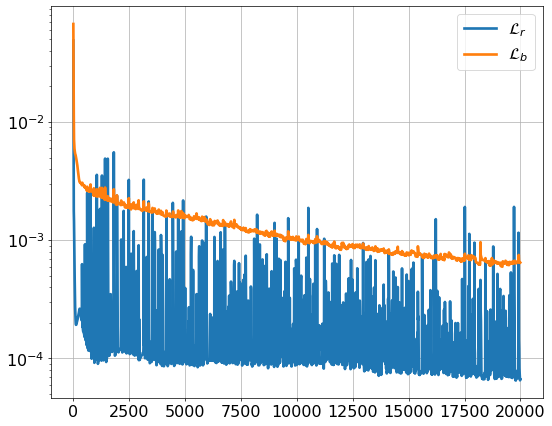

In [16]:
# loss图
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()
fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 10
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_bcs"][::k], label=r"$\mathcal{L}_{b}$", linewidth=3)
ax.set_yscale('log')
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的loss图 (包括只经backbone和经过transformer和backbone的loss)

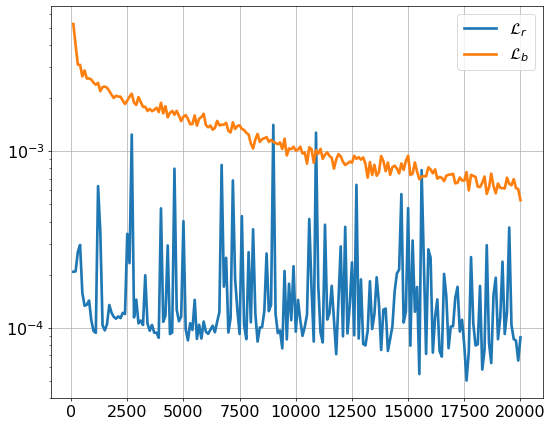

In [17]:
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

ax.plot(loss_logger_valid["iter"], loss_logger_valid["loss_res"], label=r"$\mathcal{L}_{r}$", linewidth=3)
ax.plot(loss_logger_valid["iter"], loss_logger_valid["loss_bcs"], label=r"$\mathcal{L}_{b}$", linewidth=3)
ax.set_yscale('log')
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('loss_valid.png', dpi=100, bbox_inches='tight')
plt.show()

### Relative L2 error (仅考虑内部点）

In [18]:
# 使用最好的模型
backbone = ResNet(args.backbone_layers)
state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
backbone.load_state_dict(state_dict['state_dict'])
backbone.eval()
print("Iter:\t", state_dict['iter'] + 1)
print("Loss:\t", "{:.2e}".format(state_dict['best_loss']))

Iter:	 20001
Loss:	 6.16e-04


In [46]:
# def exact_sol(X):
#     # 解析解
#     u_star = X.mean(axis=1, keepdims=True)
#     u_star = u_star**2 + np.sin(u_star)
#     return u_star

# # 采样内部点
# dataset = Dataset_PoissonHD(args.bot_top, args.dim, torch.device('cpu'))
# X_res, _, _, _ = dataset.train_data(N_r=10000, N_b=0)
# # 计算u_star u_pred
# u_star = exact_sol(X_res)
# u_pred = backbone(X_res)

# u_star = u_star.detach().numpy()
# u_pred = u_pred.detach().numpy()
# #计算L2相对误差
# error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
# with open("RL2.txt", 'w') as f:
#     f.write(str(error_u))
# print('Relative L2 error: {:.3e}'.format(error_u))

### 可视化t=1 $(x_1, x_2, 1)$

In [44]:
x1 = np.linspace(0, 1, 101)
x2 = np.linspace(-1, 1, 101)
X1, X2 = np.meshgrid(x1, x2)

X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
T = np.ones((X.shape[0], 1)) * 1.
X = np.concatenate([X, T], axis=1)
X = torch.from_numpy(X).float()

u1u2vp = backbone(X)
u1u2vp = u1u2vp.detach().cpu().numpy()

U_x1 = u1u2vp[:, [0]].reshape(X1.shape)
U_x2 = u1u2vp[:, [1]].reshape(X1.shape)
V = u1u2vp[:, [2]].reshape(X1.shape)
P = u1u2vp[:, [3]].reshape(X1.shape)

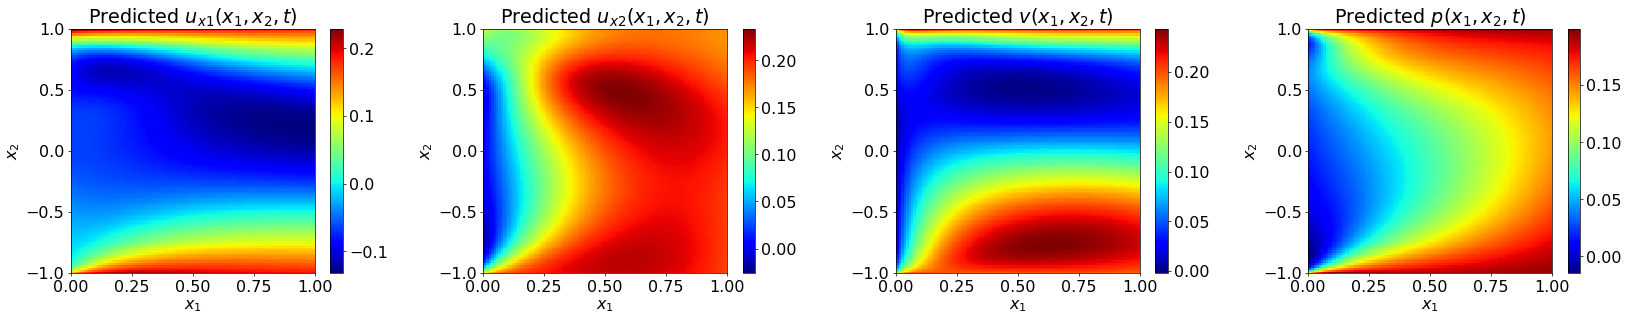

In [45]:
fig = plt.figure(figsize=(26, 5), dpi=64)
axes = fig.subplots(1, 4)

cax1 = axes[0].pcolor(X1, X2, U_x1, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Predicted $u_{x1}(x_1, x_2, t)$')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_xticks(np.arange(0, 1.1, 0.25))
axes[0].set_yticks(np.arange(-1, 1.1, 0.5))
axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].pcolor(X1, X2, U_x2, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u_{x2}(x_1, x_2, t)$')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_xticks(np.arange(0, 1.1, 0.25))
axes[1].set_yticks(np.arange(-1, 1.1, 0.5))
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].pcolor(X1, X2, V, cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title(r'Predicted $v(x_1, x_2, t)$')
axes[2].set_xlim([0, 1])
axes[2].set_ylim([-1, 1])
axes[2].set_xticks(np.arange(0, 1.1, 0.25))
axes[2].set_yticks(np.arange(-1, 1.1, 0.5))
axes[2].set_aspect(1./axes[2].get_data_ratio())

cax4 = axes[3].pcolor(X1, X2, P, cmap='jet')
fig.colorbar(cax4)
axes[3].set_xlabel('$x_1$')
axes[3].set_ylabel('$x_2$')
axes[3].set_title(r'Predicted $p(x_1, x_2, t)$')
axes[3].set_xlim([0, 1])
axes[3].set_ylim([-1, 1])
axes[3].set_xticks(np.arange(0, 1.1, 0.25))
axes[3].set_yticks(np.arange(-1, 1.1, 0.5))
axes[3].set_aspect(1./axes[3].get_data_ratio())

plt.tight_layout()
plt.show()

In [ ]:
##################################################
################ Check All(t=1) ################
##################################################

plt.rcParams.update({'font.size':18})
fig = plt.figure(3, figsize=(17, 15))

#################### u ####################
plt.subplot(3, 3, 1)
plt.pcolor(XX, YY, U_star[1], cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Reference $u(t,x,y)$')
plt.tight_layout()

plt.subplot(3, 3, 2)
plt.pcolor(XX, YY, U_pred[1], cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(t,x,y)$')
plt.tight_layout()

plt.subplot(3, 3, 3)
plt.pcolor(XX, YY, np.abs(U_star[1]-U_pred[1]), cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Absolute error')
plt.tight_layout()

#################### v ####################
plt.subplot(3, 3, 4)
plt.pcolor(XX, YY, V_star[1], cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Reference $v(t,x,y)$')
plt.tight_layout()

plt.subplot(3, 3, 5)
plt.pcolor(XX, YY, V_pred[1], cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Predicted $v(t,x,y)$')
plt.tight_layout()

plt.subplot(3, 3, 6)
plt.pcolor(XX, YY, np.abs(V_star[1]-V_pred[1]), cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Absolute error')
plt.tight_layout()

#################### w ####################
plt.subplot(3, 3, 7)
plt.pcolor(XX, YY, W_star[1], cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Reference $w(t,x,y)$')
plt.tight_layout()

plt.subplot(3, 3, 8)
plt.pcolor(XX, YY, W_pred[1], cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Predicted $w(t,x,y)$')
plt.tight_layout()

plt.subplot(3, 3, 9)
plt.pcolor(XX, YY, np.abs(W_star[1]-W_pred[1]), cmap='jet')
plt.colorbar()
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'Absolute error')
plt.tight_layout()

plt.savefig(f'{file}/predict.png', dpi=200, bbox_inches = 'tight')
plt.show()